# Applying the model

```




```
- [Read data](#Read-data)
- [Prepare data](#Prepare-data)
- [Create and train model](#Create-and-train-model)
- [Test on unseen data](#Test-on-unseen-data)

In [1]:
import os
import sys
import json
import pickle

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
# import config

%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
MODULES_PATH = '../modules'
MODELS_PATH = '../models'
DATA_PATH = '../data'
TWEETS_PATH = '../data/tweets'

sys.path.append(MODULES_PATH)
from data import flatten_data, prepare_training_data, prepare_test_data
from models import simple_ffn

Using TensorFlow backend.


## Read data

In [71]:
# https://www.loc.gov/standards/iso639-2/php/code_list.php
language_codes = pd.read_csv(os.path.join(DATA_PATH,'language_codes.csv'))

In [72]:
language_code_1 = language_codes.loc[~language_codes['ISO 639-1 Code'].isnull()]

In [81]:
language_code_1.index = language_code_1['ISO 639-1 Code']

In [89]:
language_code_1 = language_code_1.drop_duplicates()

In [75]:
language_code_1.head()

,ISO 639-2 Code,ISO 639-1 Code,English name of Language,French name of Language,German name of Language
0,aar,aa,Afar,afar,Danakil-Sprache
1,abk,ab,Abkhazian,abkhaze,Abchasisch
8,afr,af,Afrikaans,afrikaans,Afrikaans
10,aka,ak,Akan,akan,Akan-Sprache
12,alb (B),sq,Albanian,albanais,Albanisch


In [79]:
pedi = pd.DataFrame({'ISO 639-2 Code':['nso'],'ISO 639-1 Code':['nso'],'English name of Language':['Pedi']})
language_code_1 = language_code_1.append(pedi, ignore_index=True)

In [7]:
twitter_files = os.listdir(TWEETS_PATH)
twitter_files

['tugboat-isiNdebele on Twitter - export - 20180423.csv',
 'tugboat-isiXhosa on Twitter v1 - export - 20180423.csv',
 'tugboat-isiZulu on Twitter v1 - export - 20180423.csv',
 'tugboat-isiZulu on Twitter v2 - export - 20180423.csv',
 'tugboat-SePedi on Twitter - export - 20180423.csv',
 'tugboat-SeSotho on Twitter - export - 20180423.csv',
 'tugboat-SeTswana on Twitter - export - 20180423.csv',
 'tugboat-SiSwati on Twitter - export - 20180423.csv',
 'tugboat-TshiVenda on Twitter - export - 20180423.csv',
 'tugboat-Xitsonga on Twitter - export - 20180423.csv']

In [8]:
LANG_KEY = ['nr','xh','zu','zu','nso','st','tn','ss','ve','ts']

In [26]:
for idx, file in enumerate(twitter_files):
    if idx == 0:
        tweets = pd.read_csv(os.path.join(TWEETS_PATH,file), encoding="ISO-8859-1")
        tweets['our_lang'] = LANG_KEY[idx]
        print(tweets.shape)
    else:
        new_tweets = pd.read_csv(os.path.join(TWEETS_PATH,file), encoding="ISO-8859-1")
        new_tweets['our_lang'] = LANG_KEY[idx]
        print(new_tweets.shape)
        tweets = tweets.append(new_tweets, ignore_index=True)    

(69317, 26)
(101510, 26)
(122315, 26)
(41154, 26)
(21378, 26)
(17823, 26)
(67514, 26)
(47416, 26)
(49791, 26)
(34196, 26)


In [27]:
tweets.index

RangeIndex(start=0, stop=572414, step=1)

In [90]:
query_lang_name = language_code_1.loc[tweets['our_lang']]['English name of Language']

In [91]:
twitter_lang_name = tweets.merge(language_code_1, left_on='lang', right_on ='ISO 639-1 Code', how='left')['English name of Language']

/mnt/c/Users/Thembanip/Documents/py/sa-language-classifier/sa_lang_env/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: 'ISO 639-1 Code' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


In [93]:
query_lang_name.value_counts()

Zulu                             163469
Xhosa                            101510
Ndebele, South; South Ndebele     69317
Tswana                            67514
Venda                             49791
Swati                             47416
Tsonga                            34196
Pedi                              21378
Sotho, Southern                   17823
Name: English name of Language, dtype: int64

In [94]:
twitter_lang_name.value_counts()

English                          196029
Tagalog                           66749
Portuguese                        40473
Japanese                          23078
Estonian                          11101
Haitian; Haitian Creole            9315
Turkish                            8658
Spanish; Castilian                 7767
Hindi                              7256
French                             5419
German                             5219
Finnish                            4961
Italian                            4696
Slovenian                          2650
Polish                             2442
Tamil                              2085
Romanian; Moldavian; Moldovan      1940
Welsh                              1644
Russian                            1135
Dutch; Flemish                      919
Thai                                879
Czech                               852
Korean                              810
Catalan; Valencian                  510
Greek, Modern (1453-)               459


In [95]:
tweets['query_lang_name'] = query_lang_name.tolist()
tweets['twitter_lang_name'] = twitter_lang_name.tolist()

## Prepare data

In [44]:
with open(os.path.join(DATA_PATH, 'pipeline_instance.pickle'),'rb') as datafile:
        pipeline_instance = pickle.load(datafile)

In [45]:
document_matrix, labels = prepare_test_data(tweets['text'], 
                                            tweets['our_lang'], 
                                            pipeline_instance)

In [46]:
document_matrix.shape, labels.shape

((572414, 2346), (572414, 9))

## Create and train model

In [47]:
from keras.models import load_model

model = load_model(os.path.join(MODELS_PATH,'simple_model.h5'))

In [48]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2346)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          300416      input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128)          0           dense_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128)          0           activation_1[0][0]               
__________________________________________________________________________________________________
batch_norm

## Apply the model

In [49]:
pred = model.predict(document_matrix)

In [50]:
predictions = pd.DataFrame(pred, columns=labels.columns)
predictions.head()

,nr,nso,ss,st,tn,ts,ve,xh,zu
0,0.017990,0.047326,4.865678e-03,1.501317e-04,1.731087e-06,2.129493e-05,2.885310e-05,3.392841e-06,0.929614
1,0.225054,0.097279,2.688050e-01,1.766390e-01,2.325999e-02,1.463932e-02,9.651159e-02,1.744072e-02,0.080372
2,0.979664,0.000394,1.249260e-02,6.731069e-04,1.600152e-04,2.726377e-04,4.839024e-04,9.297595e-05,0.005767
3,0.000096,0.000603,6.858457e-08,3.822840e-10,1.114045e-14,7.829541e-12,1.251553e-11,3.373587e-13,0.999301
4,0.406909,0.039692,2.967108e-01,8.207060e-02,3.243324e-04,2.090610e-04,2.188924e-02,4.660909e-04,0.151729


In [51]:
predicted_class = predictions.apply(lambda x: x.argmax(),axis=1)

/mnt/c/Users/Thembanip/Documents/py/sa-language-classifier/sa_lang_env/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


In [52]:
predicted_class.value_counts().sort_values()

xh       1155
tn      15858
ts      24132
ve      54444
st      57594
nso     70364
nr     100599
ss     116962
zu     131306
dtype: int64

In [53]:
max_prob = predictions.apply(lambda x: x.max(),axis=1)

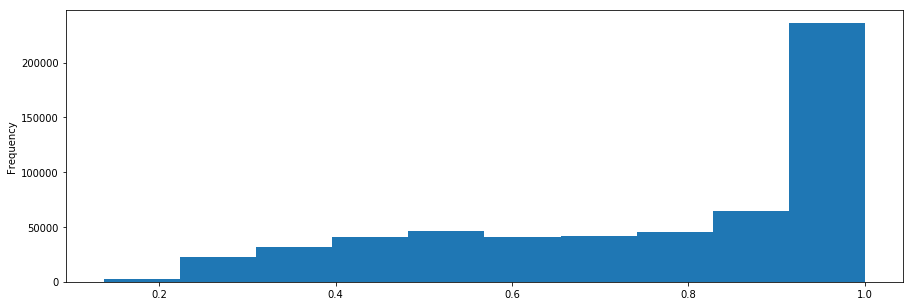

In [54]:
max_prob.plot.hist(figsize=(15,5))

In [97]:
tweets = tweets.join(predictions)
tweets['pred_lang'] = predicted_class.tolist()
tweets['max_prob']  = max_prob.tolist()

In [98]:
tweets['pred_lang_name'] = language_code_1.loc[tweets['pred_lang']]['English name of Language'].tolist()

In [99]:
tweets.head().T

,0,1,2,3,4
created_at,Mon Apr 23 2018 09:05:57 GMT+0000 (UTC),Mon Apr 23 2018 09:05:52 GMT+0000 (UTC),Mon Apr 23 2018 09:05:44 GMT+0000 (UTC),Mon Apr 23 2018 09:04:37 GMT+0000 (UTC),Mon Apr 23 2018 09:04:22 GMT+0000 (UTC)
id_str,988343205111451649,988343185155022849,988343151873155074,988342868480872448,988342806417756160
text,@magomakede @KLouw15 @KaizerChiefs yibarry ley...,RT @golhr: Cavsi su ponovno imali 16 poena pre...,""" Dala ngiwela emaWuwani(Emawani)\nDala ngibha...",RT @czapruk: I was never ready ! Phambili nge ...,Feel like a lost soul.Ppl be talking about Car...
lang,in,und,tl,en,en
user.screen_name,KenethZondo,DNEVNIKhr,CrookedSwiri,Bassy_Kojane,Thabizolo20
user.name,Skhura's Bistor,DNEVNIK.hr,Swiri_017,Basetsana,Thabizolo Msimang
user.id_str,937964918896283648,80316128,4757078293,885847624145920000,808774016223899648
user.description,follow back if you don't mind let's have fun a...,Saznajte prvi najvaÅ¾nije informacije: https:/...,Recording Artist & CEO @Snupeâ¢\nEmail addres...,Follower of Christð|\nWits graduateð|\na...,"Young,black and gifted."
user.location,"Daveyton, South Africa",Republic of Croatia,Volksrust017,"Johannesburg, South Africa","South Africa,Durban"
user.time_zone,NaN,Zagreb,NaN,NaN,NaN


In [100]:
tweets.pivot_table(index='twitter_lang_name',
                  columns='pred_lang_name',
                  values='text', aggfunc='count')

pred_lang_name,"Ndebele, South; South Ndebele",Pedi,"Sotho, Southern",Swati,Tsonga,Tswana,Venda,Xhosa,Zulu
twitter_lang_name,,,,,,,,,
Arabic,167.0,18.0,8.0,22.0,4.0,8.0,5.0,32.0,NaN
Basque,42.0,52.0,39.0,17.0,23.0,22.0,30.0,1.0,58.0
Bengali,73.0,34.0,5.0,6.0,44.0,2.0,27.0,NaN,2.0
Bulgarian,17.0,76.0,1.0,NaN,4.0,NaN,13.0,NaN,NaN
Catalan; Valencian,86.0,119.0,39.0,41.0,78.0,15.0,56.0,NaN,76.0
Chinese,2.0,3.0,1.0,1.0,NaN,NaN,3.0,NaN,NaN
Czech,138.0,104.0,68.0,109.0,32.0,7.0,159.0,NaN,235.0
Danish,44.0,48.0,28.0,52.0,13.0,NaN,32.0,1.0,46.0
Dutch; Flemish,128.0,166.0,94.0,117.0,91.0,20.0,128.0,2.0,173.0


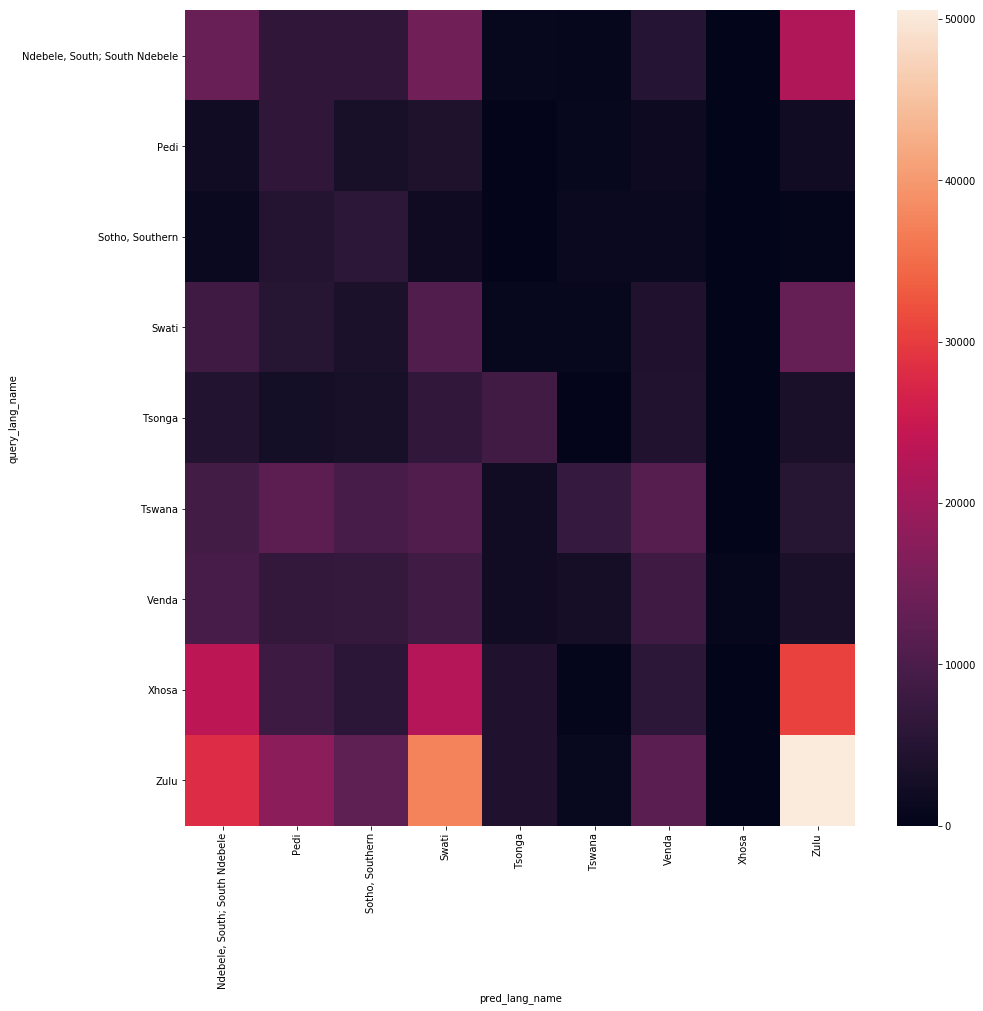

In [102]:
query_pred_pivot =  tweets.pivot_table(index='query_lang_name',
                  columns='pred_lang_name',
                  values='text', aggfunc='count')

# idx = query_pred_pivot[('Zulu')].reset_index().sort_values(('Zulu'),ascending=False).index

fig, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(query_pred_pivot, ax=ax)

## Save results

In [62]:
tweets.loc[21163]['user.description']

'I AM THE WARRIORS REMINDER\r\rI AM MYSELF'

In [104]:
tweets.to_json(os.path.join(DATA_PATH,'tweets_predicted.json'),orient='records')

**Examples**